# Classificació de cel·lules usant la U-Net

**TODO: Descripcio**

*La següent cel·la s'ha d'executar sempre*

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My Drive/u_net_folder

[Errno 2] No such file or directory: 'gdrive/My Drive/u_net_folder'
/content


In [3]:
!git clone https://github.com/bmalcover/u_cells
%cd u_cells
!git checkout 'dev/iker'
%cd ..

Cloning into 'u_cells'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 8), reused 14 (delta 5), pack-reused 0
Unpacking objects: 100% (22/22), done.
/content/u_cells
Branch 'dev/iker' set up to track remote branch 'dev/iker' from 'origin'.
Switched to a new branch 'dev/iker'
/content


**DATA**

Només executar si dins la carpeta *u_net_folder* no hi ha la carpeta *unet_color_quatre*

In [4]:
#!wget -O dataset.zip https://www.dropbox.com/s/3zfz89hik6989h5/dataset.zip?dl=1
!wget -O dataset_four.zip https://www.dropbox.com/s/0v6rdf3xhoge0vh/unet_color_quatre.zip?dl=1 
#!wget -O dataset_gt.zip https://www.dropbox.com/s/wvjlpqykck6jwc6/unet_color_tres.zip?dl=1
#!wget -O dataset_gros.zip https://www.dropbox.com/s/e7ndtiqce74gqli/sub.zip?dl=1
 
#!unzip dataset.zip
!unzip dataset_four.zip > /dev/null
#!unzip dataset_gt.zip
#!unzip dataset_gros.zip

--2021-02-28 15:39:07--  https://www.dropbox.com/s/0v6rdf3xhoge0vh/unet_color_quatre.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/0v6rdf3xhoge0vh/unet_color_quatre.zip [following]
--2021-02-28 15:39:08--  https://www.dropbox.com/s/dl/0v6rdf3xhoge0vh/unet_color_quatre.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5f899fda1cfe5337485c7dda8e.dl.dropboxusercontent.com/cd/0/get/BJwPNwVKzgSyG4iPfy8QIhaNBRQRxYa_26B2tF85abTWNtKuUZ4fjmdabQ8elUQF-5mI-r08uqiV3eALBtyyijAtl54bBMZO3sPaMR2oQl6QIupsn7LCiQKVJt7tSe9bQOg/file?dl=1# [following]
--2021-02-28 15:39:08--  https://uc5f899fda1cfe5337485c7dda8e.dl.dropboxusercontent.com/cd/0/get/BJwPNwVKzgSyG4iPfy8QIhaNBRQRxYa_26B2tF85abTWNtKuUZ4fjmdabQ8elUQF-5mI-r08uqiV3eALBt

Llibreries

In [5]:
# %tensorflow_version 1.x
import io
from datetime import datetime

from matplotlib import pyplot as plt

from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import metrics
import keras
import keras.backend as K
from PIL import Image


import numpy as np
import cv2

seed(1)
#print(tf.__version__)

Funcionalitats propies



In [6]:
%cd u_cells/

from model import *
from data import *

%cd ..

/content/u_cells
/content


### Preparació de les dades i generació de la xarxa
---

In [7]:
test_path_root = "./unet_color_quatre/test/image/"
test_path = test_path_root + "*.png"
train_path = './unet_color_quatre/train'
generator_path = None #'./generator5/'
tb_dir = "./log/" + datetime.now().strftime("%Y/%m/%d-%H:%M:%S")
# tb_cb = keras.callbacks.TensorBoard(tb_dir, write_graph=True, update_freq=10)

data_gen_args = dict(rotation_range=0.2,
						width_shift_range=0.05,
						height_shift_range=0.05,
						shear_range=0.05,
						zoom_range=0.05,
						horizontal_flip=True,
						fill_mode='nearest')

train_generator = trainGenerator(2, train_path,'image','label',data_gen_args,save_to_dir = generator_path, mask_color_mode = "rgb", decode_flag=True, target_size=(512,512)) #AQui
val_generator = trainGenerator(2, './unet_color_quatre/test','image','label',data_gen_args,save_to_dir = generator_path, mask_color_mode = "rgb", decode_flag=True, target_size=(512,512)) #AQui

model = get_small_unet(n_filters=64, bn = True, input_size=(512,512,1), output_channels = 3, loss_func = dice_coef_loss) ### AqUI!!!!!
# model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
#tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

### Entrenament
---

In [8]:
model.fit(train_generator, validation_data = val_generator, validation_steps=100, steps_per_epoch=300, epochs=10) # 300, 5

Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 0.2523 - categorical_accuracy: 0.4393Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
300/300 [==============================] - 347s 1s/step - loss: 0.2522 - categorical_accuracy: 0.4392 - val_loss: 0.2559 - val_categorical_accuracy: 0.1997
Epoch 2/10
300/300 [==============================] - 329s 1s/step - loss: 0.2236 - categorical_accuracy: 0.3895 - val_loss: 0.2279 - val_categorical_accuracy: 0.4451
Epoch 3/10
300/300 [==============================] - 328s 1s/step - loss: 0.2191 - categorical_accuracy: 0.3765 - val_loss: 0.2282 - val_categorical_accuracy: 0.5027
Epoch 4/10
300/300 [==============================] - 328s 1s/step - loss: 0.2170 - categorical_accuracy: 0.3898 - val_loss: 0.2261 - val_categorical_accuracy: 0.5103
Epoch 5/10
300/300 [==============================] - 327s 1s/step - loss: 0

### Resultats - avaluació
---


In [9]:
testGene = testGenerator(test_path, target_size=(512, 512))
results = model.predict(testGene, 16)

In [10]:
plt.rcParams["figure.figsize"] = (30,15)

In [11]:
def remove_border_cells(contours, shape):
    """
    Removes the objects from the borders of the image.

    A border of an image is the zone near the start or the end of the matrix. 
    The index of this points are near 0 and near the shape of the image. The 
    contours checked as a parameter don't has that exactly index so is needed 
    to has an acceptable error.

    Args:
        contours: List of numpy arrays, every array its a different contour. The array has two
                  columns and many rows as points in the contour. Depending of the appoximation
                  method used
        shape:

    Returns:

    """
    center_contours = []

    for cont in contours:
        cont = np.squeeze(cont)
        border = not np.all(
            (cont[:, 0] > 15) & (cont[:, 1] > 15) & (cont[:, 0] < shape[1] - 15) &
            (cont[:, 1] < shape[0] - 15))

        if not border:
            center_contours.append(np.array([cont]).reshape((cont.shape[0], 1, 
                                                             cont.shape[1])))

    return center_contours

def get_iou(ground, prediction, th, debug=False, remove_border_segs = False):
  assert ground.shape[2] == prediction.shape[2]
  
  ground = ground.astype(np.float32) / ground.max()
  ious = [0] * ground.shape[2]
  
  if debug:
    fig = plt.figure(1,(16, 12))
    idx = 1

  for channel_idx in range(0, ground.shape[2]):

    channel_gt = ground[:,:, channel_idx]
    channel_pred = np.copy(prediction[:, :, channel_idx])
    
    channel_pred = cv2.resize(channel_pred, (channel_gt.shape[1], channel_gt.shape[0]), interpolation = cv2.INTER_NEAREST) 

    channel_pred[channel_pred <= th] = 0
    channel_pred[channel_pred > th] = 1

    if remove_border_segs:
      contours, _ = cv2.findContours((channel_pred * 255).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
      contours = remove_border_cells(contours, channel_pred.shape)

      channel_pred = np.zeros_like(channel_pred)
      channel_pred = cv2.drawContours(channel_pred, contours, -1, 1, -1)
 
    intersection = cv2.bitwise_and(channel_gt, channel_pred)
    intersection_area = np.count_nonzero(intersection)
    
    union = cv2.bitwise_or(channel_gt, channel_pred)
    union_area = np.count_nonzero(union)
    
    if debug:
      l = [channel_gt, channel_pred, intersection, union, (union-intersection)]
      titles = ["GT", "PRED", "INTERSEC", "UNION", "DIFF"]
    
      for i in range(len(l)):
        plt.title(titles[(i-1) % 5])
        plt.subplot(3,5, idx)
        plt.imshow(l[i], cmap="gray");
        idx += 1
    
    ious[channel_idx] += round(intersection_area / union_area, 3)
    
  return ious

In [12]:
alpha = 0.5

ious = []
for idx, res in enumerate(results):
  gt_image = cv2.imread("./unet_color_quatre/test/label/" + str(idx) + ".png")
  # cv2 reads the images in BGR we convert them into rgb
  gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB) 

  gt_image = decode(gt_image)

  iou = get_iou(gt_image, res, alpha)
  ious.append(iou)

  if idx < 10:
    print("Image 0"+ str(idx) + ": " + str(iou))
  else:
    print("Image "+ str(idx) + ": " + str(iou))

print("###########################################")
print("Mean: ", np.mean(ious, axis = 0))

Image 00: [0.0, 0.807, 0.738]
Image 01: [0.0, 0.653, 0.522]
Image 02: [0.118, 0.834, 0.69]
Image 03: [0.01, 0.724, 0.381]
Image 04: [0.006, 0.56, 0.587]
Image 05: [0.012, 0.711, 0.547]
Image 06: [0.23, 0.793, 0.638]
Image 07: [0.141, 0.723, 0.543]
Image 08: [0.15, 0.757, 0.621]
Image 09: [0.101, 0.747, 0.592]
Image 10: [0.028, 0.561, 0.594]
Image 11: [0.409, 0.796, 0.702]
Image 12: [0.076, 0.692, 0.711]
Image 13: [0.0, 0.805, 0.81]
Image 14: [0.043, 0.732, 0.689]
Image 15: [0.082, 0.633, 0.651]
Image 16: [0.0, 0.833, 0.629]
###########################################
Mean:  [0.08270588 0.72711765 0.62617647]


La següent cel·la només serveix per evaluar el funcionament de _get_iou_

[0.0, 0.724, 0.068]

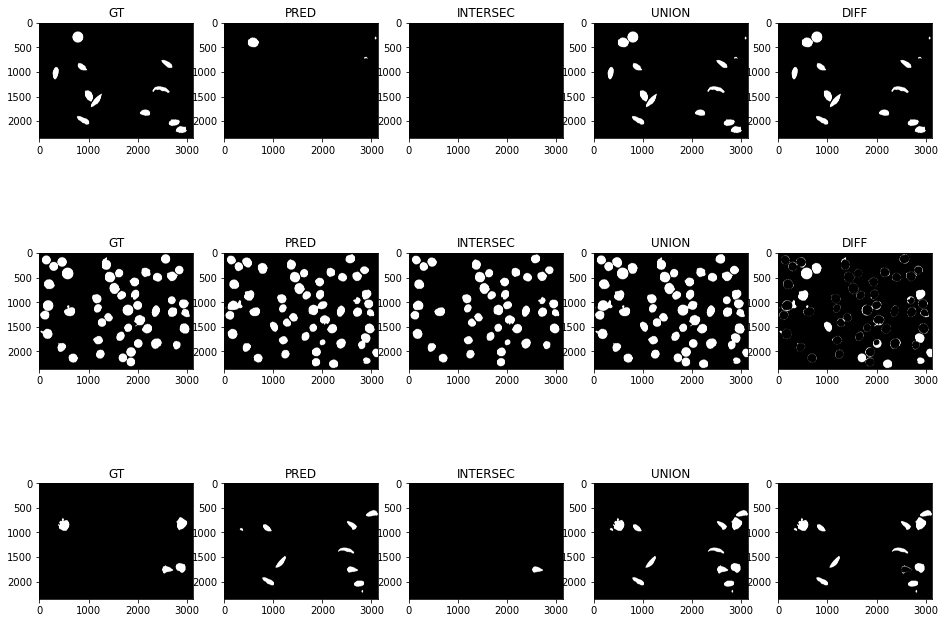

In [13]:
index = 3

ground = cv2.imread("./unet_color_quatre/test/label/" + str(index) + ".png")
prediction = results[index]
th = 0.5
ground = decode(ground)
get_iou(ground, prediction, th, True)

<tf.Tensor: shape=(512, 512), dtype=float32, numpy=
array([[0.25316566, 0.25451535, 0.25808716, ..., 0.2536425 , 0.2549026 ,
        0.25119603],
       [0.25148278, 0.25042617, 0.25503552, ..., 0.25024146, 0.25226748,
        0.25508314],
       [0.25147492, 0.2541495 , 0.2707904 , ..., 0.25590146, 0.2516157 ,
        0.2506888 ],
       ...,
       [0.25023043, 0.25089782, 0.25012106, ..., 0.25012565, 0.2566905 ,
        0.25051725],
       [0.25095814, 0.2517842 , 0.26517928, ..., 0.25068837, 0.25502193,
        0.25008112],
       [0.25144863, 0.2570582 , 0.25020552, ..., 0.25365895, 0.2522012 ,
        0.253922  ]], dtype=float32)>

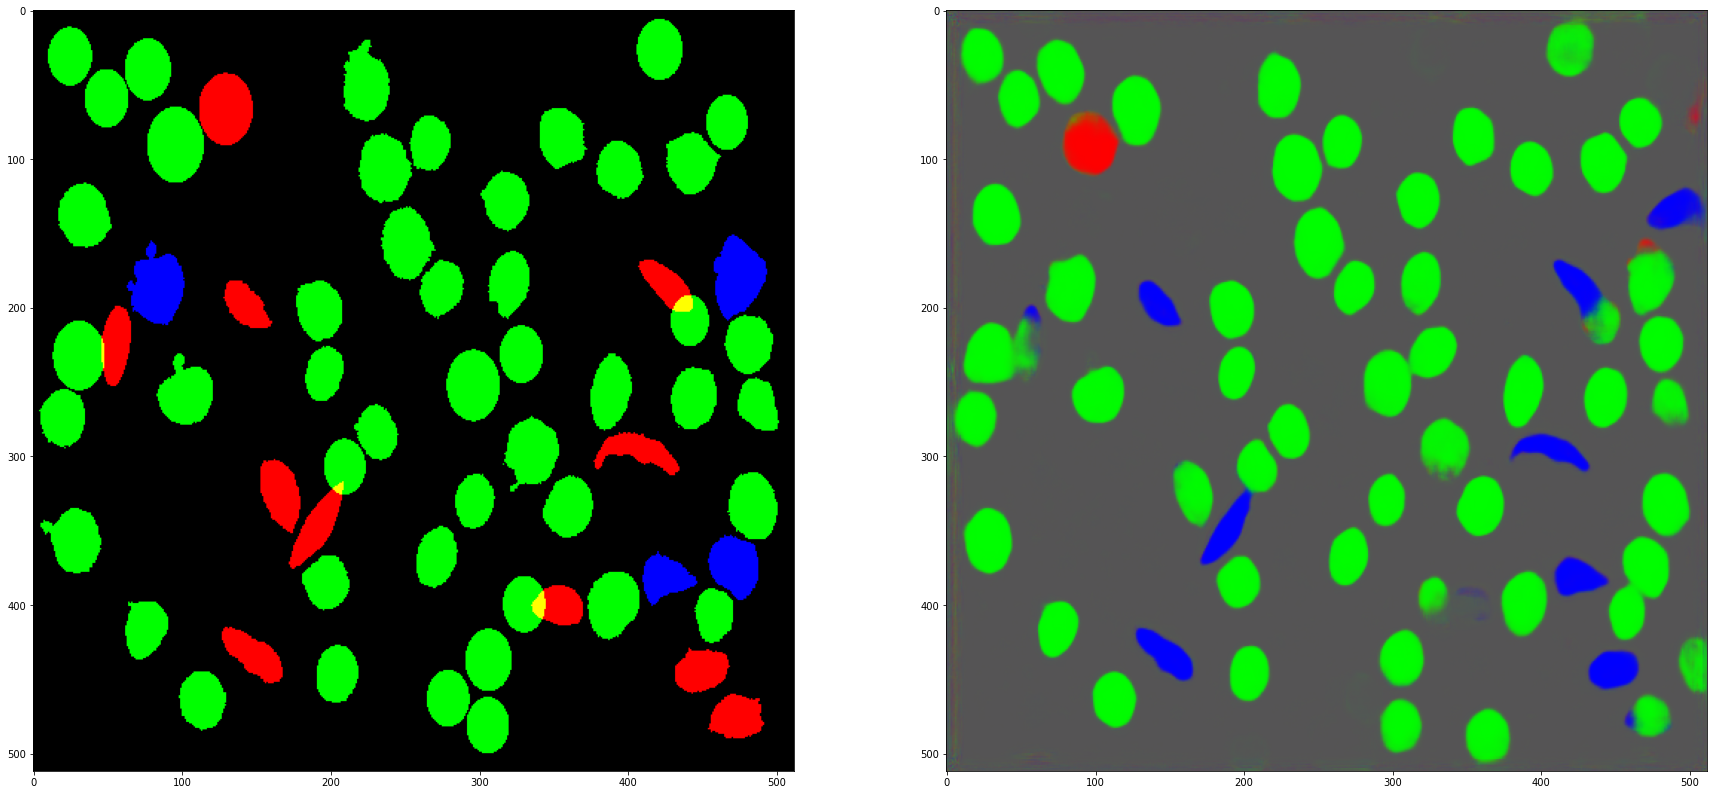

In [14]:
#BRUTOR
index = 3
ground = cv2.imread("./unet_color_quatre/test/label/" + str(index) + ".png")
ground = decode(ground)

ground = cv2.resize(ground, (512, 512), interpolation = cv2.INTER_NEAREST) 
prediction = results[index]

g = K.constant(ground)
p = K.constant(prediction)
        # y_true, y_pred

plt.subplot(1,2, 1)
plt.imshow(ground, cmap="gray");
plt.subplot(1,2, 2)
plt.imshow(prediction, cmap="gray");

dice_coef_loss(g, p)


Visualització dels resultats en format *RAW*

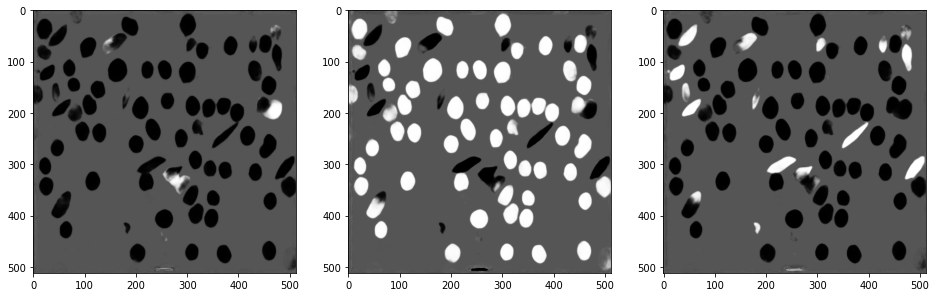

In [15]:
res = results[6] # Canviar aquest index per veure diferents imatges

fig = plt.figure(1,(16,12))
dim = res.shape[2]
for i in range(dim):
  plt.subplot(1, dim, i+1)
  plt.imshow(res[:,:,i], cmap="gray");

Guardar resultats en una carpeta anomenada Out

*Nota: Es sobreescriuen els resultats anteriors*

In [17]:
import os

!rm -rf out/
!mkdir out

for idx, r in enumerate(results):
  for c_idx in range(0, r.shape[2]):
    path = "./out/" + str(c_idx) + "/"
    if not os.path.exists(path): 
      os.makedirs(path)

    cv2.imwrite(path + str(idx) + ".png", r[:,:,c_idx]*255)

In [18]:
from google.colab import files

!zip -r ./out.zip ./out > /dev/null
files.download("./out.zip");

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>